# 오르면 팔고 떨어지면 사는 전략을 백테스트로 검증하기
- 전략 근거
  - 주가는 진동한다.
  - 주가에는 overshoot이 있어 적정 가격에서 벗어난 후 복귀하는 성질이 있다
- 전략
  - TOTAL_BUDGET만큼 예산을 잡는다.
  - total_amount를 days만큼 나눠서 매일 살 금액 amount를 확보한다.
  - 첫 번째 매수 : 특정 날 종가에 amount만큼 산다.
  - 매일 최대 한 번씩 매수, 매도한다.
  - 전날 종가보다 주가가 sell_percent% 오르면 amount만큼 판다.
  - 전날 종가보다 주가가 buy_percent% 내리면 amount만큼 산다.
  - 자금을 모두 사용한 경우에는
    1. 절반을 다음날 시가(or 종가)에 손절하고 전략을 이어간다.
    2. 모두 다음날 시가(or 종가)에 손절하고 전략을 이어간다.
  - profit_limit_percent만큼 이익이 발생한 경우에는 전량 매도한다.

In [1]:
from marcap import marcap_data
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from src.classes.Account import Account
from src.classes.Strategy import Strategy

df_2023 = marcap_data('2023-01-01', '2023-06-30')
df_2023.head()

,Code,Name,Close,Dept,ChangeCode,Changes,ChagesRatio,Volume,Amount,Open,High,Low,Marcap,Stocks,Market,MarketId,Rank
Date,,,,,,,,,,,,,,,,,
2023-01-02,005930,삼성전자,55500,NaN,1,200,0.36,10031448,558433491400,55500,56100,55200,331322931525000,5969782550,KOSPI,STK,1
2023-01-02,373220,LG에너지솔루션,446000,NaN,1,10500,2.41,250046,112200536500,442000,455000,441500,104364000000000,234000000,KOSPI,STK,2
2023-01-02,207940,삼성바이오로직스,827000,NaN,1,6000,0.73,33010,27329403000,831000,833000,822000,58860898000000,71174000,KOSPI,STK,3
2023-01-02,000660,SK하이닉스,75700,NaN,1,700,0.93,1376985,104385549300,75100,76700,75000,55109779030500,728002365,KOSPI,STK,4
2023-01-02,051910,LG화학,604000,NaN,1,4000,0.67,108253,65915777000,596000,620000,596000,42637775172000,70592343,KOSPI,STK,5


In [2]:
BUDGET = 10000000 # 천만 원

yoonwoo_account = Account('윤우계좌', BUDGET)
yoonwoo_account.show_account()

이름: 윤우계좌
잔고: 10,000,000원
보유 주식: {}


In [3]:
STRATEGY_NAME = '윤우전략'
STRATEGY_BUDGET = BUDGET
DIVIDE_NUMBER = 5
BUY_PERCENT = -0.02
SELL_PERCENT = 0.02
PROFIT_LIMIT_PERCENT = 0.1
STOCK_NAME = '삼성전자'
DAYS = 60

yoonwoo_strategy = Strategy(STRATEGY_NAME, STRATEGY_BUDGET, DIVIDE_NUMBER,
                             BUY_PERCENT, SELL_PERCENT, PROFIT_LIMIT_PERCENT,
                               STOCK_NAME, df_2023, yoonwoo_account)

yoonwoo_strategy.show_strategy()

전략 이름: 윤우전략
전략 예산: 10,000,000원
일별 예산: 2,000,000원
분할 매수 횟수: 5회
매수 기준 하락룰: -2.00%
매도 기준 상승률: 2.00%
전체 익절 상한 수익률: 10.00%
매매 대상 주식: 삼성전자
매매 대상 주식 데이터: 
Code                    005930
Name                      삼성전자
Close                    55500
Dept                       NaN
ChangeCode                   1
Changes                    200
ChagesRatio               0.36
Volume                10031448
Amount            558433491400
Open                     55500
High                     56100
Low                      55200
Marcap         331322931525000
Stocks              5969782550
Market                   KOSPI
MarketId                   STK
Rank                         1
Name: 2023-01-02 00:00:00, dtype: object


# 누적 수익률 구하는 것부터 하기

In [4]:
# 20일간의 삼성전자 주가 변화에 따른 매매
for i in range(DAYS):
    if i == 0:
        yoonwoo_strategy.first_buy_strategy(i)
        continue
    yoonwoo_strategy.buy_strategy(i)
    yoonwoo_strategy.sell_strategy(i)


삼성전자 주식을 144개 전량 매도했습니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
삼성전자 주식을 91개 전량 매도했습니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
삼성전자 주식을 77개 전량 매도했습니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
잔액이 부족헤 종가에 반을 매도합니다.
삼성전자 주식을 92개 전량 매도했습니다.


In [5]:
yoonwoo_account.show_account()

이름: 윤우계좌
잔고: 4,133,816.3100000042원
보유 주식: {'삼성전자': {'count': 128, 'purchase_amount': 7849408}}


In [6]:
open, close, high, low = yoonwoo_strategy._get_now_price_data(60 - 1)
yoonwoo_account.get_stock_earning_rate(STOCK_NAME, close)

0.022446533547498104

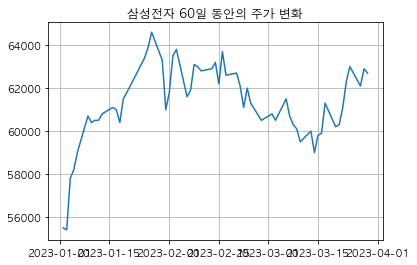

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')

plt.plot(yoonwoo_strategy.target_df.head(60)['Close'])
plt.title(f'{STOCK_NAME} {DAYS}일 동안의 주가 변화')
plt.grid()
plt.show()